In [1]:
import pandas as pd
import numpy as np 
import pymc as pm 
import matplotlib.pyplot as plt 
import arviz as az 
import pytensor as pt
import matplotlib as mpl 
from cycler import cycler

# matplotlib default parameters
plt.style.use('default')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['red', 'black', 'green', 'blue', 'magenta', 'cyan', 'orange', 'violet'])
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 12   
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['errorbar.capsize'] = 4

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def inspect_columns(df):
    # A summary of the dataset
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_prop': round((df.isnull().sum() / len(df)), 4),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result.to_markdown()

In [3]:
df = pd.read_csv('../stock_data/prices.csv')
df = df[df.ticker == 'MSI']
df.rename(columns = {'Close' : 'close', 'Date' : 'date'}, inplace = True)
df = df[['date', 'close']]
df['return'] = df['close'].pct_change()
df['lnS'] = np.log(df['close'])
print(inspect_columns(df))

|        | unique   |   cardinality | with_null   |   null_prop | 1st_row            | random_row           | last_row             | dtype   |
|:-------|:---------|--------------:|:------------|------------:|:-------------------|:---------------------|:---------------------|:--------|
| date   | True     |          6144 | False       |      0      | 2000-01-03         | 2003-08-14           | 2024-06-04           | object  |
| close  | False    |          4734 | False       |      0      | 179.69586181640625 | 34.805519104003906   | 369.2200012207031    | float64 |
| return | False    |          6034 | True        |      0.0002 | nan                | 0.037756158879867385 | 0.007696526668107495 | float64 |
| lnS    | False    |          4734 | False       |      0      | 5.191265765235022  | 3.549775969148221    | 5.911392675648591    | float64 |


<Axes: xlabel='date'>

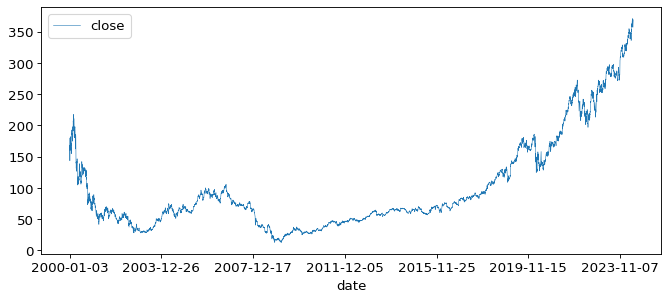

In [4]:
df.plot(x = 'date', y = 'close', linewidth = 0.5, figsize = [10,4])

### Our Brownian Motion Bayesian Model
An asset may be modelled as a Wiener process, which follows a SDE. This is, of course, imperfect, but is actually quite robust. We aim to estimate an asset's instantaneous Sharpe ratio historically, fitting to a discretized stochastic process.
We consider the price of the stock, $S$, to obey the following stochastic differential equation:
$$
\frac{dS}{S} = \mu (t) dt + \sigma(t) dX
$$
Where $\mu$ is the drift, $\sigma$ parametrizes the magnitude of volatility and $dX$ refers to a differential Brownian process. If we take $dt$ to be finite (we take it to be one trading day, for each closing price), then it becomes a recursive differencing equation, which is easily modelled by PyMC with the operation "scan". When modelling $\mu$, we can get as fancy as we want -- one may consider seasonality. We will just enforce that $\mu$ and $\sigma$ must be somewhat close to their previous values -- ie, that $\mu$ and $\log(\sigma)$ are random walks.
$$
S_t - S_{t-1} = S_{t-1} ( \mu (t) \Delta t + \sigma(t) X) \quad X \sim \mathcal{N}(0,1/\sqrt{\Delta t})
$$
Where we now impose Brownian conditions on our parameters:
$$
\mu(t) \sim \mathcal{P}(\text{mean} = \mu(t-1), \theta), \quad \log(\sigma(t)) \sim \mathcal{Q}(\text{mean} = \log(\sigma(t-1)), \theta)
$$
The Sharpe ratio is given by:
$$
\text{SR} = \frac{\mathbb{E}[\frac{\Delta S}{S}]}{\text{STD}[\frac{\Delta S}{S}]}
$$
Where now $\Delta S$ is typically given by the difference in returns in units of years. We can however, estimate the instantaneous yearly Sharpe ratio by using the assumption of it being a simpler Brownian motion with cosntant diffusion, meaning the expected log returns follows a normal distribution. Assuming $\mu$ and $\sigma$ are constant (this is approximately true for short timescales), we have an analytical solution for the price of the stock in a years time (it will follow a log-normal distribution). The stock in this model behaves as a simple random walk, for which, the solution for for large t is given:
$$
dS/S = d \ln S = (\mu dt + \sigma dX) \implies \ln S (t) \sim \mathcal{N}(S_0 + \mu t , t\sigma^2)
$$
We can derive the approximate instantaneous Sharpe ratio:
$$
\text{SR} = \frac{t \mu}{\sigma t^{1/2}} = t^{1/2}\frac{\mu}{\sigma}
$$
I find it is much more stable to model the logarithm of price, since this is normally distributed, whereas price is log-normally distributed.

In [6]:
df = df[-500:]
print(np.log(df['close']).diff().mean(), np.log(df['close']).diff().std())

0.0010571944252359001 0.013651034150777295


We model this using PyMC, where we have hyperpriors on the variance of $\{\mu^{(t)}\}_{t=1^T}$ and $\{\sigma^{(t)}\}_{t=1}^T$. Both of these parameters are assumed to be uncorrelated (considering correlation is a fun next step) gaussian SRWs as a prior. Another prior is that $dX$ samples iid from a student-T distribution. I chose student-T over a normal distribution because it has fatter tails, and stock dynamics are known to have fat tails (they are more akin to Levy flights than random walks). Finally, we use pytensor scan to apply a recursive update to the log of the stock price, for which we can supply observations. Since we know stock price exactly, I've chosen a very tight normal likelihood (to be kind to our sampler). In the same vein, we supply log prices to the likelihood rather than exponentiation first.

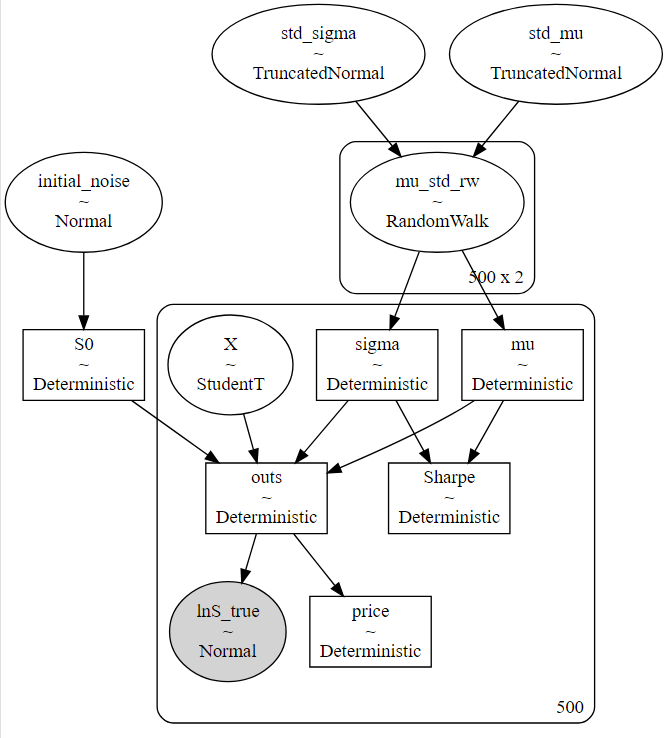

In [7]:
from pytensor.tensor.subtensor import set_subtensor

len_obs = len(df)

t = np.arange(len_obs)
lnS_t = df.lnS.values

coords = {'time' : np.arange(len_obs),
          'mu_std' : ['mu', 'std']}


def asset_price_step(mu_t, sigma_t, X_t, lnS_tm1):

    return lnS_tm1 + (mu_t + sigma_t * X_t)



with pm.Model(coords=coords) as model:

    # Hyperpriors
    #std_drift = pm.TruncatedNormal('std_drift', mu = 0.002, sigma = 0.006, lower = 0)
    #std_sigma = pm.TruncatedNormal('std_sigma', mu = 0.870, sigma = 0.395, lower = 0)

    # priors
    #mu = pm.GaussianRandomWalk(
    #    'mu',
    #    init_dist = pm.Normal.dist(mu = 0, sigma = 0.05),
    #    sigma = std_drift, dims = 'time'
    #)
    #
    #log_sigma = pm.GaussianRandomWalk(
    #    'log_sigma',
    #    init_dist = pm.Normal.dist(mu = -4, sigma = 0.1),
    #    sigma = std_sigma, dims = 'time'
    #)

    #cholesky, corr, stds  = pm.LKJCholeskyCov(
    #    'covariance',
    #    n = 2,
    #    eta = 2,
    #    #sd_dist = pm.TruncatedNormal.dist(mu = [0.001, 0.001], sigma = [0.001, 0.00001], lower = 0, shape = 2),
    #    sd_dist = pm.Exponential.dist(lam = [100, 1e6]),
    #    compute_corr = True,
    #    shape = 2
    #)
    var_mu = pm.TruncatedNormal('std_mu', mu = 0.5e-2, sigma = 1e-2, lower = 0)
    var_sigma = pm.TruncatedNormal('std_sigma', mu = 0.025, sigma = 1e-2, lower = 0)
    #covariance = pm.Normal('covariance', mu = 0, sigma = 1e-2)

    mus = np.array([0, -3.6])
    sigs = pt.tensor.eye(2)
    sigs = set_subtensor(sigs[0,0], var_mu)
    sigs = set_subtensor(sigs[1,1], var_sigma)
    sigs = set_subtensor(sigs[0,1], 0)
    sigs = set_subtensor(sigs[1,0], 0)
    #sigs.eval()


    mu_std = pm.MvGaussianRandomWalk(
        'mu_std_rw',
        #nu = 2,
        mu = np.zeros(2),
        cov = np.array([[1e-3, 0], [0, 1e-3]]),#corr,
        shape = (len_obs, 2),
        init_dist = pm.MvNormal.dist(mu = mus, cov = sigs),
    )

    sigma = pm.Deterministic('sigma', pm.math.exp(mu_std[:,1]))
    mu = pm.Deterministic('mu', mu_std[:,0])

    SR = pm.Deterministic('Sharpe', np.sqrt(252) * mu/(sigma))

    X = pm.StudentT(
        'X',
        nu = 5,
        mu = 0,
        sigma = 1, shape = len_obs
    )

    ic = pm.Deterministic(name = 'S0', var = lnS_t[0] + pm.Normal('initial_noise', mu = 0, sigma = 1))

    outputs, _ = pt.scan(fn = lambda mu_t, sigma_t, X_t, lnS_tm1: asset_price_step(mu_t, sigma_t, X_t, lnS_tm1),
                        sequences=[mu, sigma, X],
                        outputs_info = dict(initial = ic, taps = [-1]),
                        strict = True
                        )
    
    outs = pm.Deterministic('outs', pm.math.clip(outputs, -100, 100))
    price = pm.Deterministic('price', pm.math.exp(outs))


    # Likelihood
    likelihood = pm.Normal('lnS_true', mu = outs, sigma = 0.01, observed = lnS_t, shape = len_obs)
 
    #print(outputs.shape.eval(), likelihood.shape.eval(), mu.shape.eval(), mu_std.shape.eval(), sigma.shape.eval(), S_t.shape, corr.shape.eval(), stds.shape.eval(), cholesky.shape.eval(), X.shape.eval())

    #model.debug()

    
    # MCMC sampling
    # sampling and prior predictive
    idata = pm.sample_prior_predictive(samples=2000, random_seed = 2)
    trace = pm.sample(tune = 2000, draws = 1000, random_seed = 7, cores = 4, progressbar = True, target_accept=.95)

Sampling: [X, initial_noise, lnS_true, mu_std_rw, std_mu, std_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_mu, std_sigma, mu_std_rw, X, initial_noise]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9131 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
trace.to_netcdf("filename.nc")
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

#### Prior Predictive

We see that the prior is comfortably nested in our prior (perhaps a bit too uninformative if anything). When we clip the values to avoid divergences, we see a weird effect happen in the prior, so we should propbably set the clip parameters to very high values.

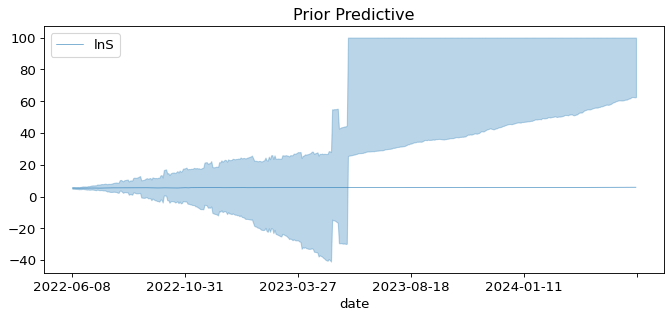

'for feat in [\'mu\', \'sigma\', \'Sharpe\']:\n\n\n    fig, ax = plt.subplots(figsize=(12, 8))\n\n    percs = np.linspace(51, 99, 40)\n    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))\n    x = np.arange(0,len(df))\n\n    cmap = plt.get_cmap("binary")\n\n    plt.title(feat)\n\n\n    for i, p in enumerate(percs[::-1]):\n        upper = np.percentile(idata.prior[feat].T.to_numpy().reshape(len_obs, int(2000)), p, axis=1)\n        lower = np.percentile(idata.prior[feat].T.to_numpy().reshape(len_obs, int(2000)), 100 - p, axis=1)\n        color_val = colors[i]\n        if i == len(percs) - 1:\n            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8, label = \'Bayesian Estimate\')\n        else:\n            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8)\n\n    plt.xticks(df.date[::10], rotation = 70)\n    if feat == \'Sharpe\':\n        plt.ylim(-10,10)\n    plt.show()\n\nfig, ax = plt.subplots(figsize=(12, 8))\n\nper

In [26]:

ax = df.plot(x = 'date', y = 'lnS', linewidth = 0.5, figsize = [10,4])
plt.title('Prior Predictive')
az.plot_hdi(
    x=df.date,
    y=idata.prior_predictive["lnS_true"],
    hdi_prob=0.4,
    color="C0",
    smooth=False,
    fill_kwargs={"label": r"HDI $67\%$", "alpha": 0.3},
    ax = ax
)


#plt.yscale('log')
#plt.xticks(df.date[::10], rotation=70)
plt.show()



'''for feat in ['mu', 'sigma', 'Sharpe']:


    fig, ax = plt.subplots(figsize=(12, 8))

    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    x = np.arange(0,len(df))

    cmap = plt.get_cmap("binary")

    plt.title(feat)


    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(idata.prior[feat].T.to_numpy().reshape(len_obs, int(2000)), p, axis=1)
        lower = np.percentile(idata.prior[feat].T.to_numpy().reshape(len_obs, int(2000)), 100 - p, axis=1)
        color_val = colors[i]
        if i == len(percs) - 1:
            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8, label = 'Bayesian Estimate')
        else:
            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8)

    plt.xticks(df.date[::10], rotation = 70)
    if feat == 'Sharpe':
        plt.ylim(-10,10)
    plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
x = np.arange(0,len(df))

cmap = plt.get_cmap("binary")

plt.title('logstd')

print(idata.prior['mu_std_rw'].to_numpy().shape)

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(idata.prior['mu_std_rw'].to_numpy().squeeze()[:,:,-1].T.reshape(len_obs, int(2000)), p, axis=1)
    lower = np.percentile(idata.prior['mu_std_rw'].to_numpy().squeeze()[:,:,-1].T.reshape(len_obs, int(2000)), 100 - p, axis=1)
    color_val = colors[i]
    if i == len(percs) - 1:
        ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8, label = 'Bayesian Estimate')
    else:
        ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8)

plt.xticks(df.date[::10], rotation = 70)
#if feat == 'Sharpe':
#    plt.ylim(-30,30)
plt.show()'''

#### Posterior Predictive Check
The PPC is looking very nice and we are comfortable in making some inferences from the posterior.

<Axes: xlabel='lnS_true'>

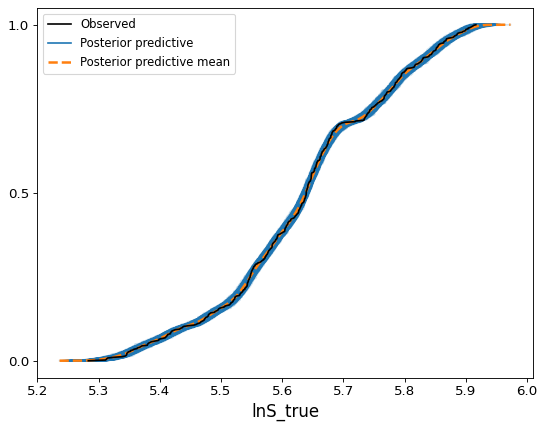

In [13]:
az.plot_ppc(trace, kind = 'cumulative')

In [14]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=10)

trace.to_netcdf("filename.nc")

Sampling: [lnS_true]


Output()

'filename.nc'

There are definitely some instabilities within the chain, and this is likely due to suboptimal parametrizations and assumptions on the nature of the distributions of this process. However, they are not egrigious, and there is probably a bit we can learn from this simple model. Let's continue!

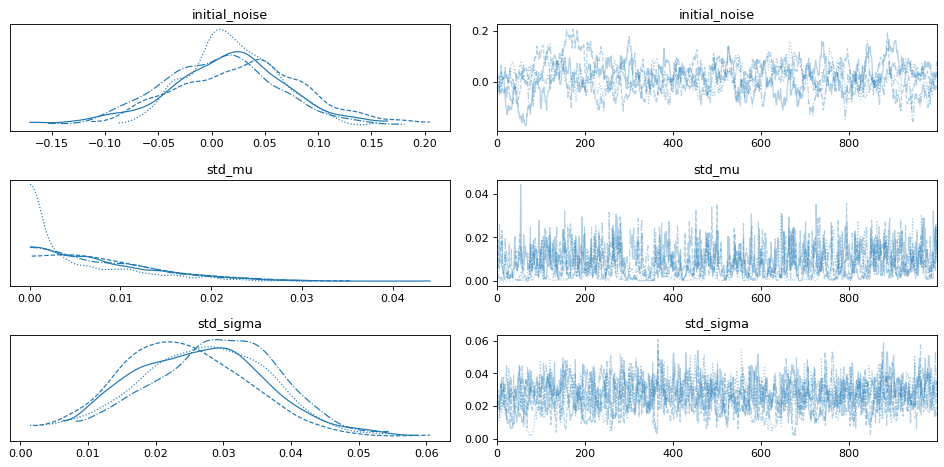

In [16]:
az.plot_trace(trace, var_names = ['initial_noise','std_mu', 'std_sigma'])
plt.tight_layout()

Posterior estimates of the stock price ad log stock price are quite good, and seem to capture a bit of volatility and much of the drift of the stock.

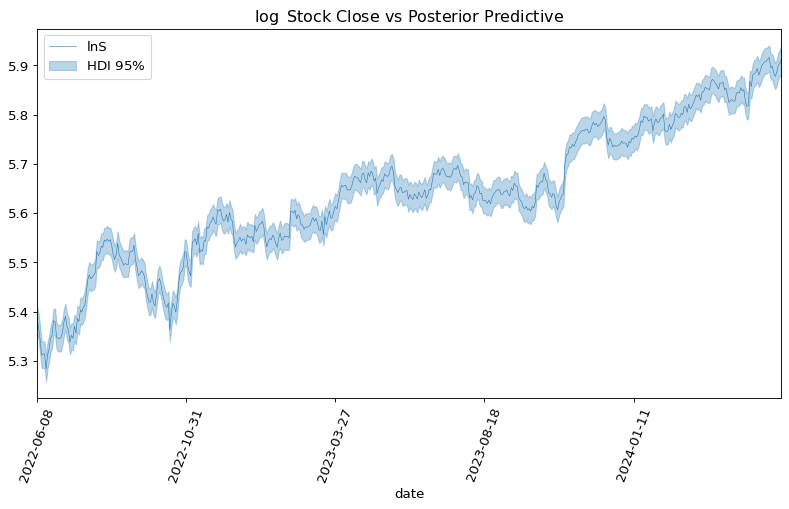

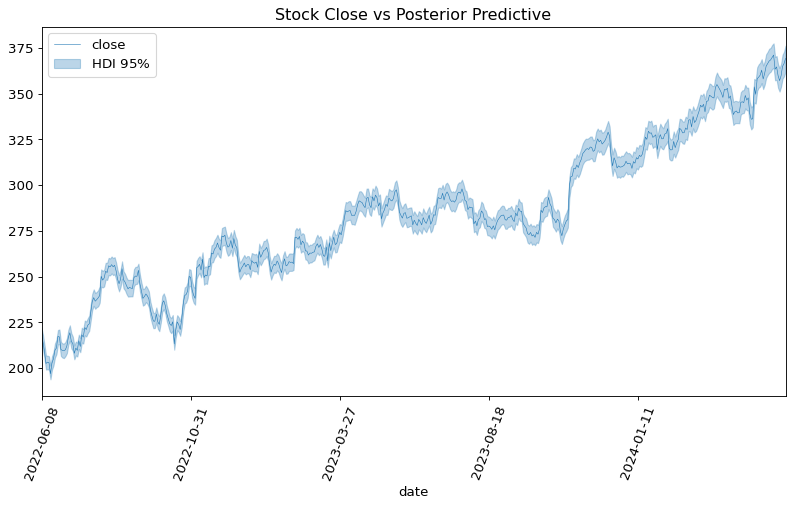

In [17]:

ax = df.plot(x = 'date', y = 'lnS', linewidth = 0.5, figsize = [12,6])
az.plot_hdi(
    x=df.date,
    y=trace.posterior_predictive["lnS_true"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": r"HDI $95\%$", "alpha": 0.3},
    ax = ax
)
plt.title(r'$\log$ Stock Close vs Posterior Predictive')
plt.legend()
#plt.yscale('log')
#plt.xticks(df.date[::10], rotation=70)
plt.xticks(rotation = 70)
plt.xlim(df.date.min(), df.date.max())
plt.show()


ax = df.plot(x = 'date', y = 'close', linewidth = 0.5, figsize = [12,6])
az.plot_hdi(
    x=df.date,
    y=trace.posterior["price"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": r"HDI $95\%$", "alpha": 0.3},
    ax = ax
)
plt.title(r'Stock Close vs Posterior Predictive')
plt.legend()
#plt.yscale('log')
#plt.xticks(df.date[::10], rotation=70)
plt.xticks(rotation = 70)
plt.xlim(df.date.min(), df.date.max())
plt.show()



Interesting to see the ever-present volatility of $\mu$ which one would assume to be relatively constant. This is the nature of the challenge of finance -- there is not free lunch. The combined uncertainty in $\mu$ and $\sigma$ compound in our estimate of the Sharpe ratio, and we see it bounces around at all times, crossing 0 regularly. This makes sense on this time-scale, and estimating a year out by assuming constant parameters is incredibly naive. Although this is the case, converting a daily SR to a yearly SR makes it much more clear the magnitude of the current performance of the stock. 10, for example, is an impossibly high ratio for stock assets, and we can see that the stock can achieve this feat on the timescale of single days.


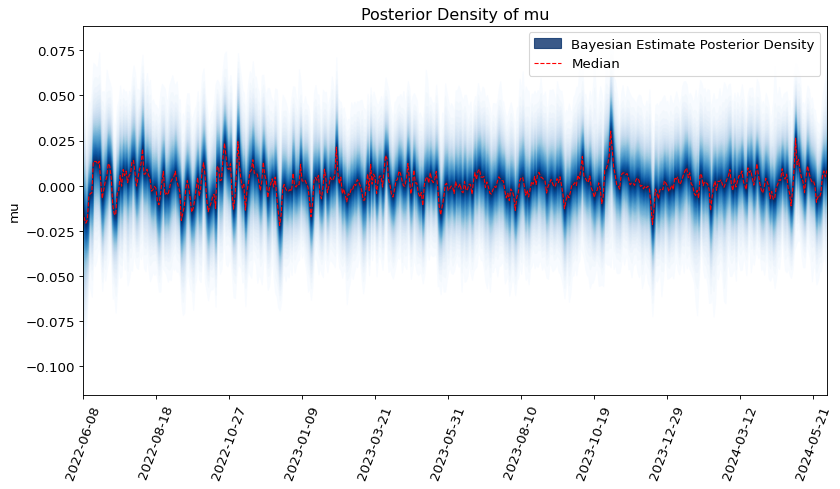

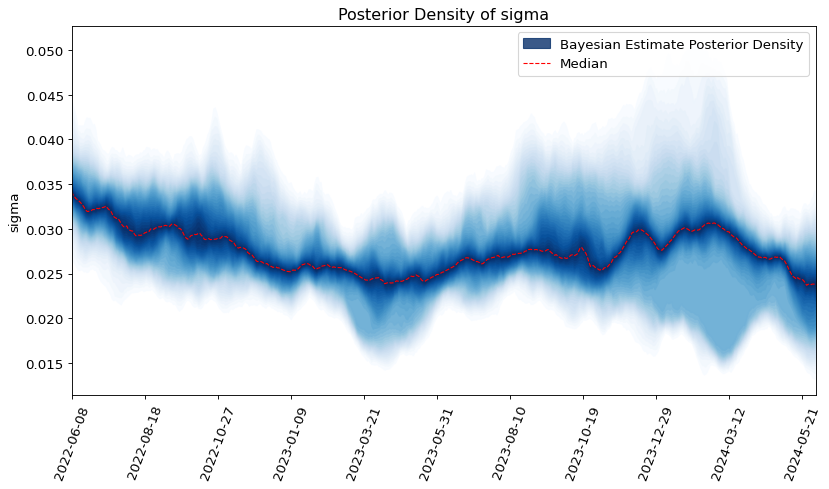

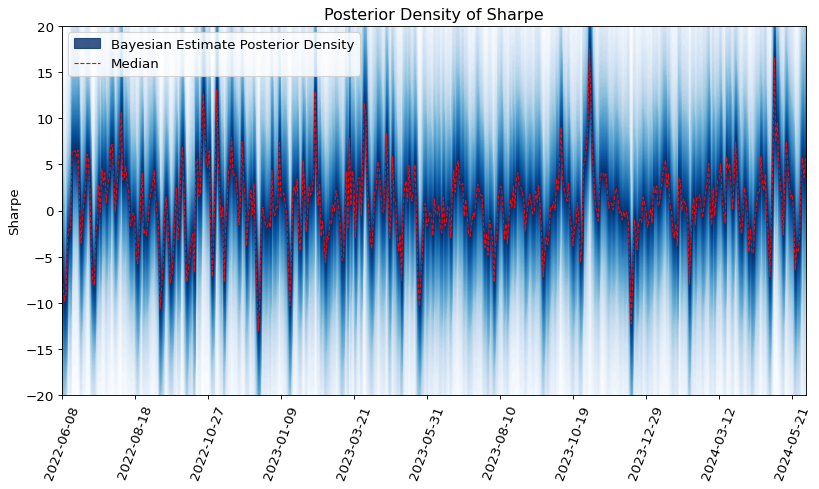

In [18]:
for feat in ['mu', 'sigma', 'Sharpe']:


    fig, ax = plt.subplots(figsize=(12, 6))

    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    x = np.arange(0,len(df))

    cmap = plt.get_cmap("Blues")

    plt.title('Posterior Density of %s' % feat)

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(trace.posterior[feat].T.to_numpy().reshape(len_obs, int(4*1000)), p, axis=1)
        lower = np.percentile(trace.posterior[feat].T.to_numpy().reshape(len_obs, int(4*1000)), 100 - p, axis=1)
        color_val = colors[i]
        if i == len(percs) - 1:
            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8, label = 'Bayesian Estimate Posterior Density')
        else:
            ax.fill_between(df.date, upper, lower, color=cmap(color_val), alpha=0.8)

    plt.plot(df.date, np.percentile(trace.posterior[feat].T.to_numpy().reshape(len_obs, int(4*1000)), 50, axis=1), color = 'red', linewidth = 1, linestyle = '--', label ='Median')

    plt.ylabel(feat)
    plt.legend()
    plt.xlim(df.date.min(), df.date.max())
    plt.xticks(df.date[::int((len(df)-1)/10)], rotation = 70)
    if feat == 'Sharpe':
        plt.ylim(-20,20)
    plt.show()

<Axes: >

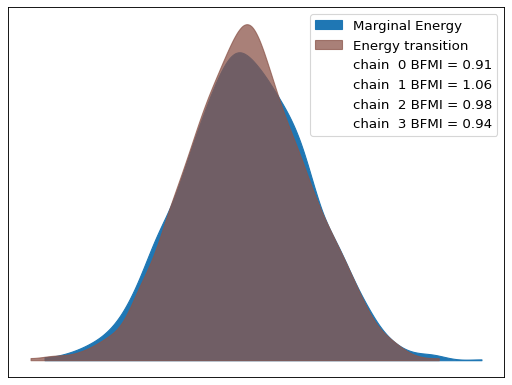

In [20]:
az.plot_energy(trace)

In [23]:
az.summary(trace, var_names = ['initial_noise','std_mu', 'std_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_noise,0.018,0.055,-0.089,0.121,0.005,0.004,125.0,128.0,1.02
std_mu,0.008,0.007,0.000,0.020,0.001,0.000,63.0,132.0,1.06
std_sigma,0.027,0.010,0.009,0.044,0.001,0.001,124.0,423.0,1.03


In [28]:
print(trace.posterior['Sharpe'].mean(), trace.posterior['Sharpe'].std())
print(np.log(trace.posterior['sigma']).mean(), np.log(trace.posterior['sigma']).std())
print(trace.posterior['mu'].mean(), trace.posterior['mu'].std())

<xarray.DataArray 'Sharpe' ()> Size: 8B
array(0.62079439) <xarray.DataArray 'Sharpe' ()> Size: 8B
array(12.85493884)
<xarray.DataArray 'sigma' ()> Size: 8B
array(-3.60509363) <xarray.DataArray 'sigma' ()> Size: 8B
array(0.20880893)
<xarray.DataArray 'mu' ()> Size: 8B
array(0.0009399) <xarray.DataArray 'mu' ()> Size: 8B
array(0.02187092)
